In [1]:
import os
import copy 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson  # 泊松分布
from scipy.stats import skellam  # skellam分布

In [2]:
# 準備資料
competitionDict = {
    82: '英超', 
    108: '意甲',
    120: '德甲',
    129: '西甲', 
    142: '法甲'
    }

sns.set_style('whitegrid')
sns.set_context('poster')
sns.set_style({'font.sans-serif':['simhei','Arial']}) #圖表顯示中文

df = pd.read_csv(os.getcwd() + '\data\matches.csv')
leagueList = [competitionDict[key] for key in df['competition_id'].values] # 聯盟名稱

Text(0.5, 0, '五大聯盟')

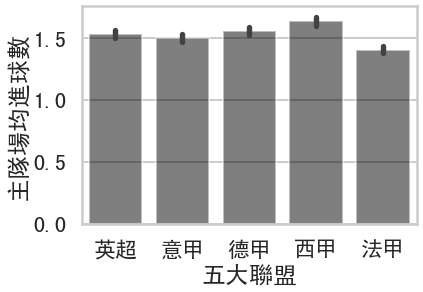

In [3]:
# 主隊場均進球數
sns.barplot(x=leagueList,  y=df["home_score"],color='black', alpha=0.5)
plt.ylabel('主隊場均進球數')
plt.xlabel('五大聯盟')

Text(0.5, 0, '五大聯盟')

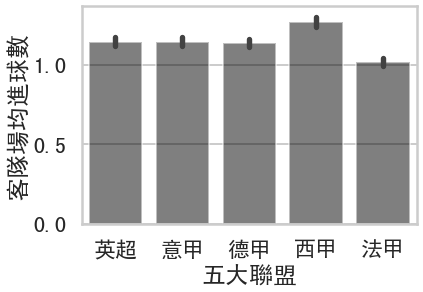

In [4]:
# 客隊場均進球數
sns.barplot(x=leagueList,  y=df["away_score"],color='black', alpha=0.5)
plt.ylabel('客隊場均進球數')
plt.xlabel('五大聯盟')

In [5]:
# 計算兩隊的總進球數
df['total_goal'] = df['home_score'] + df['away_score']

# 計算主隊與客隊之間的淨勝球
df['home_team_gd'] = df['home_score'] - df['away_score']

Text(0.5, 0, '五大聯盟')

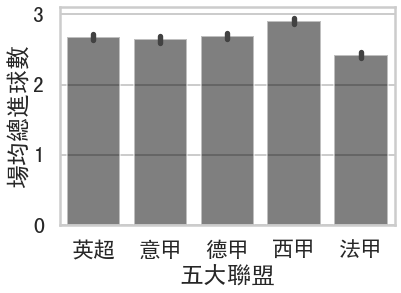

In [6]:
#場均總進球數
sns.barplot(x=leagueList,  y=df["total_goal"],color='black', alpha=0.5)
plt.ylabel('場均總進球數')
plt.xlabel('五大聯盟')

Text(0.5, 0, '五大聯盟')

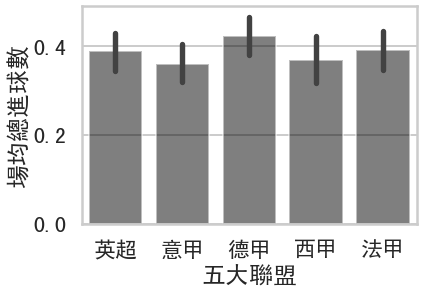

In [7]:
# 主客場均淨勝球
sns.barplot(x=leagueList,  y=df["home_team_gd"],color='black', alpha=0.5)
plt.ylabel('場均總進球數')
plt.xlabel('五大聯盟')

In [8]:
# 泊松分布
# 日常生活中，大量事件是有固定頻率的。
# 1. 某醫院平均每小時出生3個嬰兒
# 2. 某公司平均每10分鐘接到1個電話
# 3. 某超市平均每天銷售4包xx牌奶粉
# 4. 某網站平均每分鐘有2次訪問
# 它們的特點就是，我們可以預估這些事件的總數，但是沒法知道具體的發生時間。而泊松分布就是描述某段時間內，事件發生機率(λ)。

# 本案例利用泊松分佈模型對足球比賽的進球數數據進行評估
# 1. 本案例所評估 λ 就是場均進球數，因此第一步就是計算場均進球數。
# 2. 利用泊松分佈模型和場均進球數，計算出進球數的理論計算分佈。
# 3. 比較實際數據與理論計算分佈，如果非常接近，就說明足球比賽的進球數分佈服從泊松分佈。

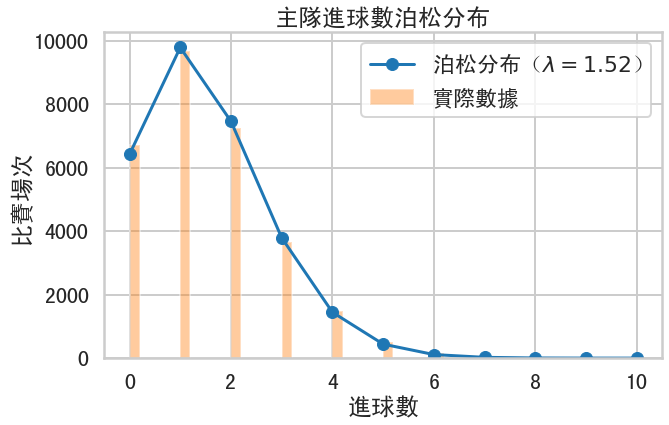

In [9]:
# 主隊進球平均
lambdaHome = df['home_score'].mean()
# 主隊最大進球數
homeMax = df['home_score'].max()

plt.figure(figsize=(10,6))
plt.plot(np.arange(homeMax + 1), poisson.pmf(np.arange(homeMax + 1), lambdaHome)*df.shape[0], '-o', label="泊松分布（$\lambda={:.2f}$）".format(lambdaHome))
sns.distplot(df['home_score'], kde=False, label='實際數據')
plt.xlabel('進球數')
plt.ylabel('比賽場次')
plt.title('主隊進球數泊松分布')
plt.legend()

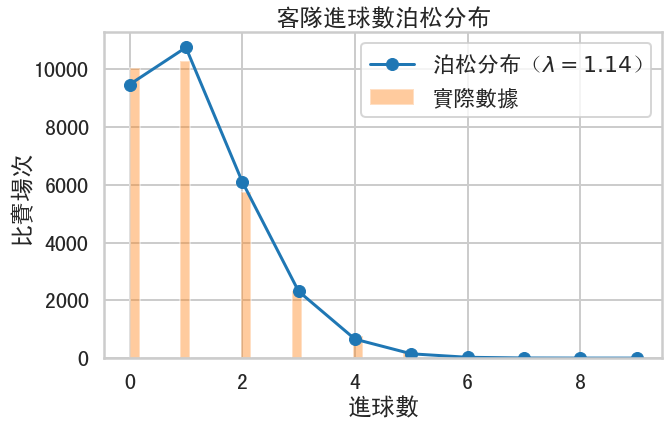

In [10]:
# 客隊進球平均
lambdaAway = df['away_score'].mean()
# 客隊最大進球數
awayMax = df['away_score'].max()

plt.figure(figsize=(10,6))
plt.plot(np.arange(awayMax + 1), poisson.pmf(np.arange(awayMax + 1), lambdaAway)*df.shape[0], '-o', label="泊松分布（$\lambda={:.2f}$）".format(lambdaAway))
sns.distplot(df['away_score'], kde=False, label='實際數據')
plt.xlabel('進球數')
plt.ylabel('比賽場次')
plt.title('客隊進球數泊松分布')
plt.legend()

In [11]:
# 從以上兩個結果可以知道，足球比賽進球數確實服從泊松分佈。
# 利用泊松分佈模型和場均進球數還可以預估出足球比賽勝平負的總體比例。
# 對比賽結果進行編碼
# 主勝：0 和：1 客勝：2
df['result'] = np.where(df['home_team_gd'] > 0, 0, np.where(df['home_team_gd'] < 0, 2, 1))
win, draw, lose = 0, 0, 0

homePoisson = poisson.pmf(np.arange(homeMax + 1), lambdaHome)
awayPoisson = poisson.pmf(np.arange(awayMax + 1), lambdaAway)

# 比分分布
predActual =  {
    '主隊三球以上' : 0,
    '客隊三球以上' :0,
    '其他': 0
}

predPrediction = copy.deepcopy(predActual)

for i in np.arange(homeMax + 1):
    for j in np.arange(awayMax + 1):

        score = str(i) + ':' + str(j)
        
        if i > 3 and j > 3:
            score = '其他'
        elif i > 3:
            score = '主隊三球以上'
        elif j > 3:
            score = '客隊三球以上'

        actual = df[(df['home_score'] == i)&(df['away_score'] == j)].shape[0]/df.shape[0]
        prediction = homePoisson[i] * awayPoisson[j]
        
        if not score == str(i) + ':' + str(j):
            actual = predActual[score] + actual
            prediction = predPrediction[score] + prediction
  
        predActual[score] = actual
        predPrediction[score] = prediction

        if i > j:
            win = win + homePoisson[i] * awayPoisson[j]
            continue
        
        if i == j:
            draw = draw +  homePoisson[i] * awayPoisson[j]
            continue

        lose = lose + homePoisson[i] * awayPoisson[j]

In [12]:
resultStatistics = df.groupby('result')

print('主隊獲勝實際比例：{:.2f}%'.format(resultStatistics.get_group(0).count()[0]/df.shape[0]*100))
print('主隊獲勝概率估計：{:.2f}%\n'.format(win*100))

print('雙方打平實際比例：{:.2f}%'.format(resultStatistics.get_group(1).count()[0]/df.shape[0]*100))
print('雙方打平概率估計：{:.2f}%\n'.format(draw*100))

print('客隊獲勝實際比例：{:.2f}%'.format(resultStatistics.get_group(2).count()[0]/df.shape[0]*100))
print('客隊獲勝概率估計：{:.2f}%\n'.format(lose*100))

主隊獲勝實際比例：46.13%
主隊獲勝概率估計：46.23%

雙方打平實際比例：25.96%
雙方打平概率估計：25.47%

客隊獲勝實際比例：27.91%
客隊獲勝概率估計：28.30%



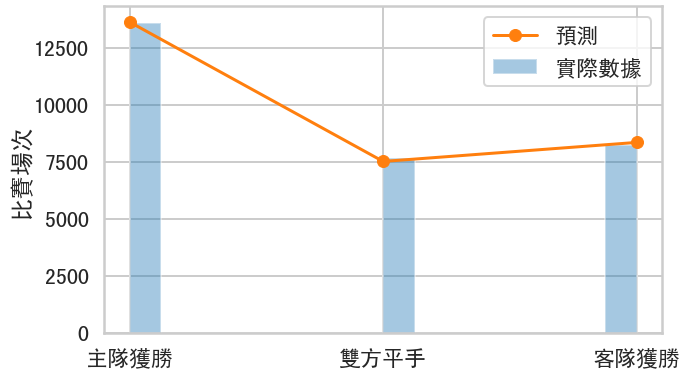

In [13]:
plt.figure(figsize=(10,6))
ax = sns.distplot(df['result'], kde=False, label='實際數據')
plt.plot(np.arange(3), df.shape[0]*np.array([win, draw, lose]), '-o', label="預測")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['主隊獲勝', '雙方平手', '客隊獲勝'])
plt.xlabel('')
plt.ylabel('比賽場次')
plt.legend()

In [14]:
print('比分預測')
print('比分 | 實際比例 | 估計比例')

for score in predActual.keys(): 
    actual = predActual[score]*100
    prediction = predPrediction[score]*100
    print('{}{:9.2f}%{:9.2f}%'.format(score, actual, prediction))

比分預測
比分 | 實際比例 | 估計比例
主隊三球以上     7.25%     6.68%
客隊三球以上     3.43%     2.65%
其他     0.20%     0.20%
0:0     8.02%     7.00%
0:1     7.09%     7.94%
0:2     4.62%     4.51%
0:3     1.94%     1.71%
1:0    10.61%    10.66%
1:1    11.88%    12.11%
1:2     6.35%     6.88%
1:3     2.68%     2.60%
2:0     8.16%     8.13%
2:1     8.92%     9.23%
2:2     4.94%     5.24%
2:3     1.77%     1.98%
3:0     4.41%     4.13%
3:1     4.42%     4.69%
3:2     2.32%     2.66%
3:3     0.99%     1.01%


In [15]:
print('依估計比例排序')
print('比分 | 實際比例 | 估計比例')
for score in sorted(predPrediction.items(), key=lambda obj: obj[1], reverse=True): 
    actual = predActual[score[0]]*100
    prediction = predPrediction[score[0]]*100
    print('{}{:9.2f}%{:9.2f}%'.format(score[0], actual, prediction))

依估計比例排序
比分 | 實際比例 | 估計比例
1:1    11.88%    12.11%
1:0    10.61%    10.66%
2:1     8.92%     9.23%
2:0     8.16%     8.13%
0:1     7.09%     7.94%
0:0     8.02%     7.00%
1:2     6.35%     6.88%
主隊三球以上     7.25%     6.68%
2:2     4.94%     5.24%
3:1     4.42%     4.69%
0:2     4.62%     4.51%
3:0     4.41%     4.13%
3:2     2.32%     2.66%
客隊三球以上     3.43%     2.65%
1:3     2.68%     2.60%
2:3     1.77%     1.98%
0:3     1.94%     1.71%
3:3     0.99%     1.01%
其他     0.20%     0.20%


In [16]:
print('依實際比例排序')
print('比分 | 實際比例 | 估計比例')
for score in sorted(predActual.items(), key=lambda obj: obj[1], reverse=True): 
    actual = predActual[score[0]]*100
    prediction = predPrediction[score[0]]*100
    print('{}{:9.2f}%{:9.2f}%'.format(score[0], actual, prediction))

依實際比例排序
比分 | 實際比例 | 估計比例
1:1    11.88%    12.11%
1:0    10.61%    10.66%
2:1     8.92%     9.23%
2:0     8.16%     8.13%
0:0     8.02%     7.00%
主隊三球以上     7.25%     6.68%
0:1     7.09%     7.94%
1:2     6.35%     6.88%
2:2     4.94%     5.24%
0:2     4.62%     4.51%
3:1     4.42%     4.69%
3:0     4.41%     4.13%
客隊三球以上     3.43%     2.65%
1:3     2.68%     2.60%
3:2     2.32%     2.66%
0:3     1.94%     1.71%
2:3     1.77%     1.98%
3:3     0.99%     1.01%
其他     0.20%     0.20%


In [17]:
# 由以上的資料可以知道，足球比賽的比分分布確實服從泊松分佈。但這樣的概念似乎與實際狀況還是有所落差
# 因此還需加入其他特徵以提早準確度